# EECS 531 - A1
### Tristan Maidment (tdm47)
### Assignment 1

#### Exercise 4

To determine the ROC curve for the template matching method in Exercise 3, I first need to calculate the True Positive Rate and False Positive Rate, as defined by the lecture slides.

The first step is to import all of the code needed to do feature detection from the previous exercise.  This contains all the methods used, and will be used to calculate the different ROC curves with different values of noise added.

In [16]:
%matplotlib inline
import cv2
import math
from matplotlib import pyplot as plt
from matplotlib import patches as patches
import numpy as np

def correlation(img, kernel):
    width, height, channels = img.shape 
    k_width, k_height = kernel.shape
    
    k_half_width = math.floor(k_width/2)
    k_half_width_2 = math.ceil(k_width/2)
    k_half_height = math.floor(k_height/2)
    k_half_height_2 = math.ceil(k_height/2)
        
    ret = np.zeros(img.shape) 
    
    img_pad = np.ones((width + k_width + 1 , height + k_width + 1, channels))
    img_pad[k_half_width : -k_half_width_2 - 1,
            k_half_height : -k_half_height_2 - 1] = img 
    
    for x in range(width):
        for y in range(height):
            for c in range(channels):
                ret[x, y, c] = np.power(np.subtract(img_pad[x: x + k_width, 
                                                            y  : y + k_height,
                                                            c], kernel), 2).sum()
    return ret/ret.max()

def create_kernel(img):
    patch = cv2.imread(img, 0)
    patch = patch/patch.max()
    width, height = patch.shape
    k_size = np.amax(patch.shape)
    ret = np.ones((k_size, k_size))
    x_diff = math.floor((k_size - width)/2)
    y_diff = math.floor((k_size - height)/2)
    ret[x_diff:k_size-x_diff,y_diff:k_size-y_diff] = patch
    return ret

def threshold(supp, t2):
    ret = np.zeros_like(supp)
    
    width, height, channels = supp.shape
    k_width, k_height = kernel.shape
    k_half_width = math.ceil(k_width/2)
    k_half_height = math.ceil(k_height/2)
    
    for x in range(k_half_width,width-k_half_width):
        for y in range(k_half_height,height-k_half_height):
                theta = np.sum(supp[x, y, :])
                if theta < t2:
                    ret[x, y, :] = 1.
                else:
                    ret[x, y, :] = 0.
    return ret

# draw rectangles
def plot_squares(img, heatmap):
    p_width, p_height, channels = heatmap.shape
    x_offset = math.floor(kernel.shape[0]/2)
    y_offset = math.floor(kernel.shape[1]/2)
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    for x in range(p_width):
        for y in range(p_height):
            if heatmap[x, y, 0] == 1.:
                rect = patches.Rectangle((y - y_offset,x - x_offset),kernel.shape[0],kernel.shape[1],linewidth=1,edgecolor='r',facecolor='none')
                ax.add_patch(rect)
    plt.show()
    #fig.savefig("./output.png", dpi=240)  # save the image to the working directory - for Exercise 4

The entirety of Example 3 is run here to ensure that everything works after moving the code over.  As expected, all 38 detections are present, with no false positives.

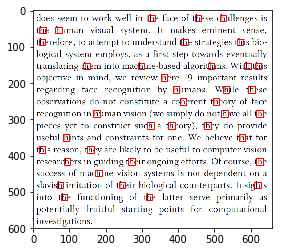

In [2]:
img = cv2.imread('./characters.png', 1) #load all three channels, due to rendering problems
if img is not None:
    b,g,r = cv2.split(img)
    img = cv2.merge((r,g,b))
img = img/img.max()

kernel = create_kernel('./h.png')
probability = correlation(img, kernel)
heatmap = threshold(probability, 0.075 * 3)
plot_squares(img, heatmap)

The function `roc_data` is used the FPR and TPR, as discussed earlier.  These will be used to plot the ROC curves.

To determine the false positives (fp), false negatives (fn), true positives (tp), and true negatives (tn), the predicted and real values using the detection matrix from Exerise 3 are used as the baseline.  If both values are the same, it is classified as a true positive or true negative respectively.  If the values differ, it is classified as a false positive or false negative.

In [17]:
def roc_data(heatmap, test):
    h_width, h_height, h_channels = heatmap.shape
    fp = 0
    fn = 0
    tp = 0
    tn = 0
    for w in range(h_width):
        for h in range(h_height):
            real = heatmap[w, h, 0]
            pred = test[w, h, 0]
            if real == pred:
                if pred > 0:
                    tp += 1
                else:
                    tn += 1
            else:
                if pred > 0:
                    fp += 1
                else:
                    fn += 1
    #38 0 0 394762
    #print(fp, fn, tp, tn)
    fpr = fp/(fp + tn) 
    tpr = tp/(tp + fn)
    return fpr, tpr

Using the `roc_data` function, the function `create_ROC` loops through different detection thresholds and plot the FPR and TPR respectively.  The TPR is represented on the Y axis and FPR on the X axis.

In [4]:
def create_ROC(heatmap, probability_test):
    x_list = []
    y_list = []
    for theta in np.arange(0.05, 0.9, 0.05):
        heatmap_test = threshold(probability_test, theta * 3)
        fpr, tpr = roc_data(heatmap, heatmap_test)
        x_list.append(fpr)
        y_list.append(tpr)
    plt.scatter(x_list, y_list)
    plt.xlim( -0.1, 1.1 )
    plt.ylim( -0.1, 1.1 )
    plt.show()

As we can see, the "perfect" threshold that was found in Exercise 3 is following the trend of "ideal behavior", according to the slides.  There are no false positives or false negatives.

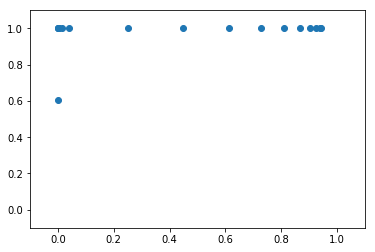

In [5]:
create_ROC(heatmap, probability)

The next step is to introduce noise into the situation to see how it alters the ROC curve.  The goal is to increase FP and FN rates.  To aid in runtime and simplicity, gray Gaussian noise is added to the image.  RGB noise requires an extra three iterations per pixel to check, and would make the runtime very long.

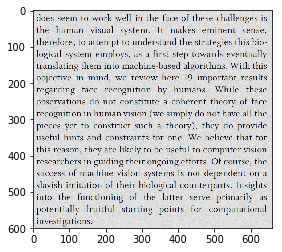

In [18]:
gray_noise = np.random.normal(0, 0.03, (img.shape[0], img.shape[1])) #mean = 0, std = 0.03
rgb_noise = np.asarray(np.dstack((gray_noise, gray_noise, gray_noise)))
img_noise = img + rgb_noise
img_noise = np.absolute(img_noise/img_noise.max())
plt.imshow(img_noise)
plt.show()

As we can see the number of detections has been lowered to 16.  There are no false negatives with the given threshold, but we can determine if some exist given the ROC curve.

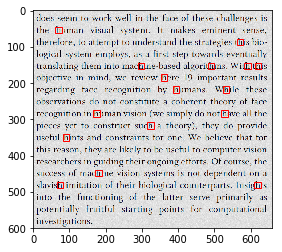

In [7]:
probability_noise = correlation(img_noise, kernel)
heatmap_noise = threshold(probability_noise, 0.075 * 3)
plot_squares(img_noise, heatmap_noise)

As we can see, there is just one case where false positives occur.  False negatives are more common, however.

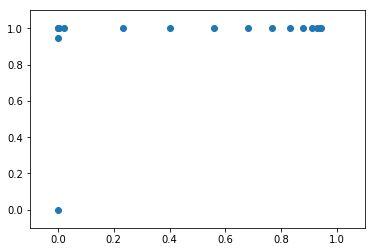

In [8]:
create_ROC(heatmap, probability_noise)

We repeat the test with a higher level of noise.

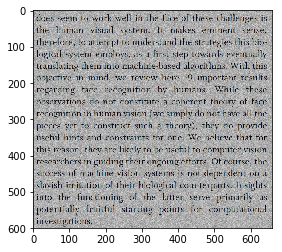

In [9]:
gray_noise = np.random.normal(0, 0.1, (img.shape[0], img.shape[1]))
rgb_noise = np.asarray(np.dstack((gray_noise, gray_noise, gray_noise)))
img_noise = img + rgb_noise
img_noise = np.absolute(img_noise/img_noise.max())
plt.imshow(img_noise)
plt.show()

This time, we can visibly see that the curve is no longer at the "ideal", which indicates lower detector performance.  It appears to be directly related to amount of noise, as expected.

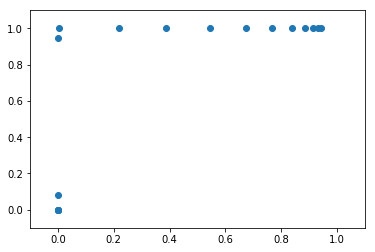

In [10]:
probability_noise = correlation(img_noise, kernel)
create_ROC(heatmap, probability_noise)

Let us try an example with a lot of noise.  We should expect to see greatly reduced detector performance.

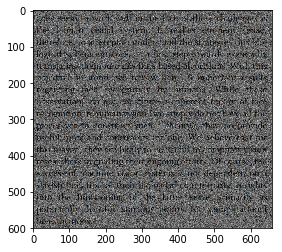

In [13]:
gray_noise = np.random.normal(0, 0.3, (img.shape[0], img.shape[1]))
rgb_noise = np.asarray(np.dstack((gray_noise, gray_noise, gray_noise)))
img_noise = img + rgb_noise
img_noise = np.absolute(img_noise/img_noise.max())
plt.imshow(img_noise)
plt.show()

As expected, detector performance has been greatly diminished, and the effects are very noticable on the ROC curve.

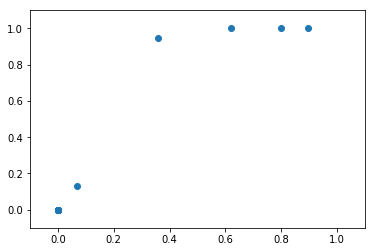

In [14]:
probability_noise = correlation(img_noise, kernel)
create_ROC(heatmap, probability_noise)